<a href="https://colab.research.google.com/github/mehdii190/neural-network/blob/main/src/CNN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ***importing***

In [111]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as db

In [112]:
mean_gray = 0.1307
stddev_gray = 0.3081

# input [channel] = (input[channel] -mean[channel])  /std[channel] 

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((mean_gray,),(stddev_gray))])


In [113]:
#train_dataset = db.MNIST(root = "data", train = True , transform = transforms, download = True)

#test_dataset = db.MNIST(root = "data",train = False,transform = transforms, download = True)

In [114]:
batch_size = 100

#train_load = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
#test_load = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)


train_loader = torch.utils.data.DataLoader(
    db.MNIST('data', train=True, download=True, transform=transform),
    batch_size=batch_size, shuffle=True)

In [115]:
test_loader = torch.utils.data.DataLoader(
    db.MNIST('data', train=False, transform=transform),
    batch_size=100)

In [116]:
len(test_loader)

100

In [117]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn1 = nn.Conv2d(in_channels= 1 , out_channels= 8 , kernel_size=3,stride=1,padding = 1)
    self.batchnorm1 = nn.BatchNorm2d(8)
    self.relu = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2)
    self.cnn2 = nn.Conv2d(in_channels= 8 , out_channels= 32 , kernel_size=5,stride=1,padding = 2)
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.fc1 = nn.Linear(1568,600)
    self.dropout = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(600,10)

  def forward(self,x):
    out = self.cnn1(x)
    out = self.batchnorm1(out)
    out = self.relu(out)
    out = self.maxpool(out)
    out = self.cnn2(out)
    out = self.batchnorm2(out)
    out = self.relu(out)
    out = self.maxpool(out)

    #  flatten the 32 feature maps from max pool to feed it to the fc1 
    out = out.view(-1,1568)
    #then we forward through our fully conn layer
    out = self.fc1(out)
    out = self.relu(out)
    out = self.dropout(out)
    out = self.fc2(out)

    return out

In [118]:
torch.cuda.is_available()

True

In [119]:
model = CNN()

CUDA = torch.cuda.is_available()

if CUDA:
  model = model.cuda()



loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

In [120]:
iteration = 0
correct = 0



for i,(input,labels) in enumerate(train_loader):

  if CUDA:
    input = input.cuda()
    labels = labels.cuda()


  print("input shape : ",input.shape)
  print("labels shape : ",labels.shape)

  output = model(input)
  print("output shape : ",output.shape )

  _ , pred = torch.max(output,1)
  print("pred shape : ",pred.shape)
  print("predicten: ")
  print(pred)
  correct += (pred==labels).sum()
  break

input shape :  torch.Size([100, 1, 28, 28])
labels shape :  torch.Size([100])
output shape :  torch.Size([100, 10])
pred shape :  torch.Size([100])
predicten: 
tensor([6, 6, 0, 9, 4, 6, 7, 4, 6, 4, 0, 6, 0, 1, 4, 6, 1, 9, 6, 6, 6, 1, 9, 6,
        0, 0, 1, 6, 1, 6, 6, 6, 6, 6, 1, 1, 6, 9, 6, 6, 6, 0, 5, 0, 6, 6, 6, 0,
        0, 2, 6, 6, 4, 6, 0, 6, 6, 0, 6, 5, 0, 9, 0, 6, 1, 1, 1, 6, 9, 1, 1, 6,
        0, 1, 0, 6, 0, 1, 6, 6, 0, 0, 6, 0, 0, 5, 9, 8, 6, 5, 1, 6, 0, 6, 1, 1,
        4, 1, 6, 6], device='cuda:0')


In [121]:
num_epochs = 10
train_loss = []
train_acc = []
test_loss = []
test_acc = []


for epoch in range(num_epochs):

  correct = 0.0
  iteration = 0.0
  iter_loss = 0.0

  model.train()

  for i ,(inputs,labels) in enumerate(train_loader):

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    output = model(inputs)
    loss = loss_fn(output,labels)
    iter_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _ , pred = torch.max(output,1)
    correct += (pred==labels).sum().item()
    iteration += 1
  
  train_loss.append(iter_loss / iteration)
  train_acc.append(100*correct / len(train_loader.dataset))

  ############## TEST ##############

  test_losss = 0.0
  correct = 0.0
  iteration = 0.0
  
  model.eval()

  for i ,(inputs,labels) in enumerate(test_loader):

    if CUDA:
      inputs = inputs.cuda()
      labels = labels.cuda()

    output = model(inputs)
    loss = loss_fn(output,labels)
    test_losss += loss.item()

    _ , pred = torch.max(output,1)
    correct += (pred==labels).sum().item()
    iteration += 1

  test_loss.append(test_losss / iteration)
  test_acc.append(100*correct / len(test_loader.dataset))


  print("Epoch {}/{} , Training Loss : {:.3f} , Training accuracy : {:.3f} , Testing Loss : {:.3f} ,Testing accuracy : {:.3f}".format(
      epoch+1,num_epochs,train_loss[-1],train_acc[-1],test_loss[-1],test_acc[-1]))




Epoch 1/10 , Training Loss : 0.510 , Training accuracy : 86.482 , Testing Loss : 0.066 ,Testing accuracy : 97.890
Epoch 2/10 , Training Loss : 0.142 , Training accuracy : 95.720 , Testing Loss : 0.049 ,Testing accuracy : 98.660
Epoch 3/10 , Training Loss : 0.105 , Training accuracy : 96.957 , Testing Loss : 0.035 ,Testing accuracy : 98.830
Epoch 4/10 , Training Loss : 0.087 , Training accuracy : 97.437 , Testing Loss : 0.036 ,Testing accuracy : 98.960
Epoch 5/10 , Training Loss : 0.077 , Training accuracy : 97.760 , Testing Loss : 0.037 ,Testing accuracy : 98.970
Epoch 6/10 , Training Loss : 0.073 , Training accuracy : 97.883 , Testing Loss : 0.043 ,Testing accuracy : 98.900
Epoch 7/10 , Training Loss : 0.068 , Training accuracy : 98.083 , Testing Loss : 0.036 ,Testing accuracy : 98.940
Epoch 8/10 , Training Loss : 0.066 , Training accuracy : 98.132 , Testing Loss : 0.033 ,Testing accuracy : 99.000
Epoch 9/10 , Training Loss : 0.057 , Training accuracy : 98.345 , Testing Loss : 0.043 ,

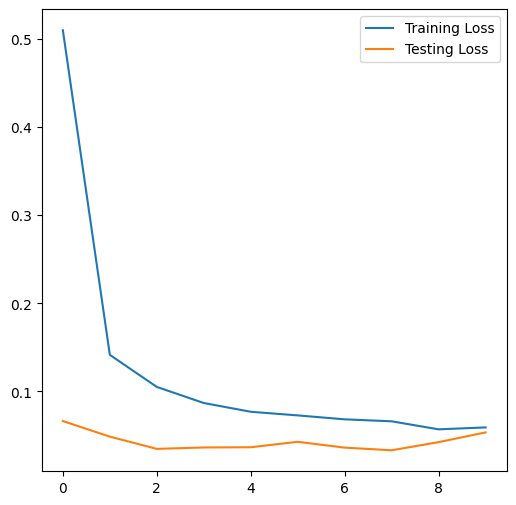

In [122]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(6,6))

plt.plot(train_loss,label = "Training Loss")
plt.plot(test_loss,label = "Testing Loss")
plt.legend()
plt.show()

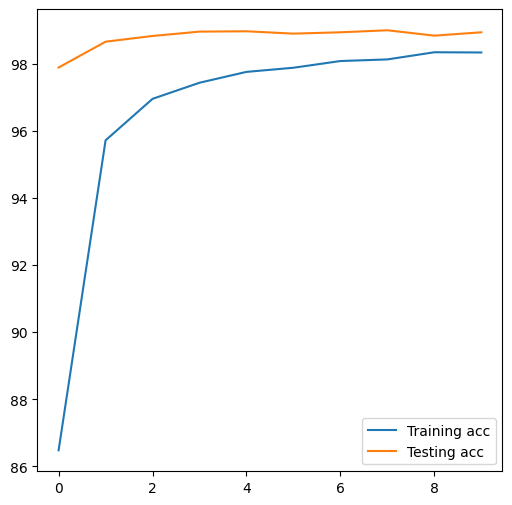

In [123]:
f = plt.figure(figsize=(6,6))

plt.plot(np.arange(len(train_loss)), train_acc,label = "Training acc")
plt.plot(np.arange(len(test_loss)), test_acc,label = "Testing acc")
plt.legend()
plt.show()

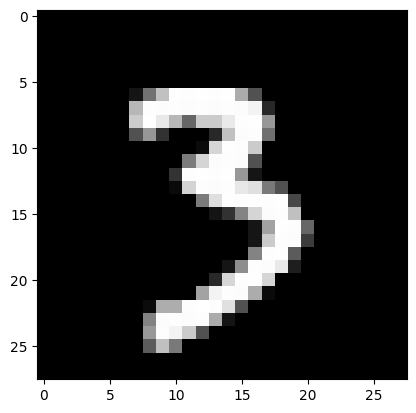

In [124]:
img = test_loader.dataset[30][0].numpy() * stddev_gray + mean_gray #.resize_((1,1,28,28))

plt.imshow(img.reshape(28,28),cmap="gray")

In [125]:
imgg = test_loader.dataset[30][0].resize_((1,1,28,28))
label = test_loader.dataset[30][1]


model = CNN()
model.eval()

if CUDA:

  model = model.cuda()
  imgg = imgg.cuda()

outputs = model(imgg)

_ , pred = torch.max(outputs,1)

print("predict is : {} ".format(pred.item()))
print("Actual is : {} ".format(label))

predict is : 4 
Actual is : 3 


In [126]:
from google.colab.patches import cv2_imshow
import cv2
from PIL import Image
from torch.autograd import Variable


transform_img = transforms.Compose([transforms.Resize((28,28)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((mean_gray,),(stddev_gray))])


def predict(img_name,model):

  image = cv2.imread(img_name,0)
  ret , thresholded = cv2.threshold(image,127,255,cv2.THRESH_BINARY)
  img = 255 - thresholded
  #img = cv2.imshow("original",img)
  img2 = cv2_imshow(img)
  #cv2.waitKey(0)
  #cv2.destroyAllWindows()
  img = Image.fromarray(img)
  img = transform_img(img)
  img = img.view(1,1,28,28)
  img = Variable(img)

  model.eval()

  if torch.cuda.is_available():

    model = model.cuda()
    img = img.cuda()

  output = model(img)
  print(output)
  print(output.data)

  _ , pred = torch.max(output,1)
  
  return pred.item()


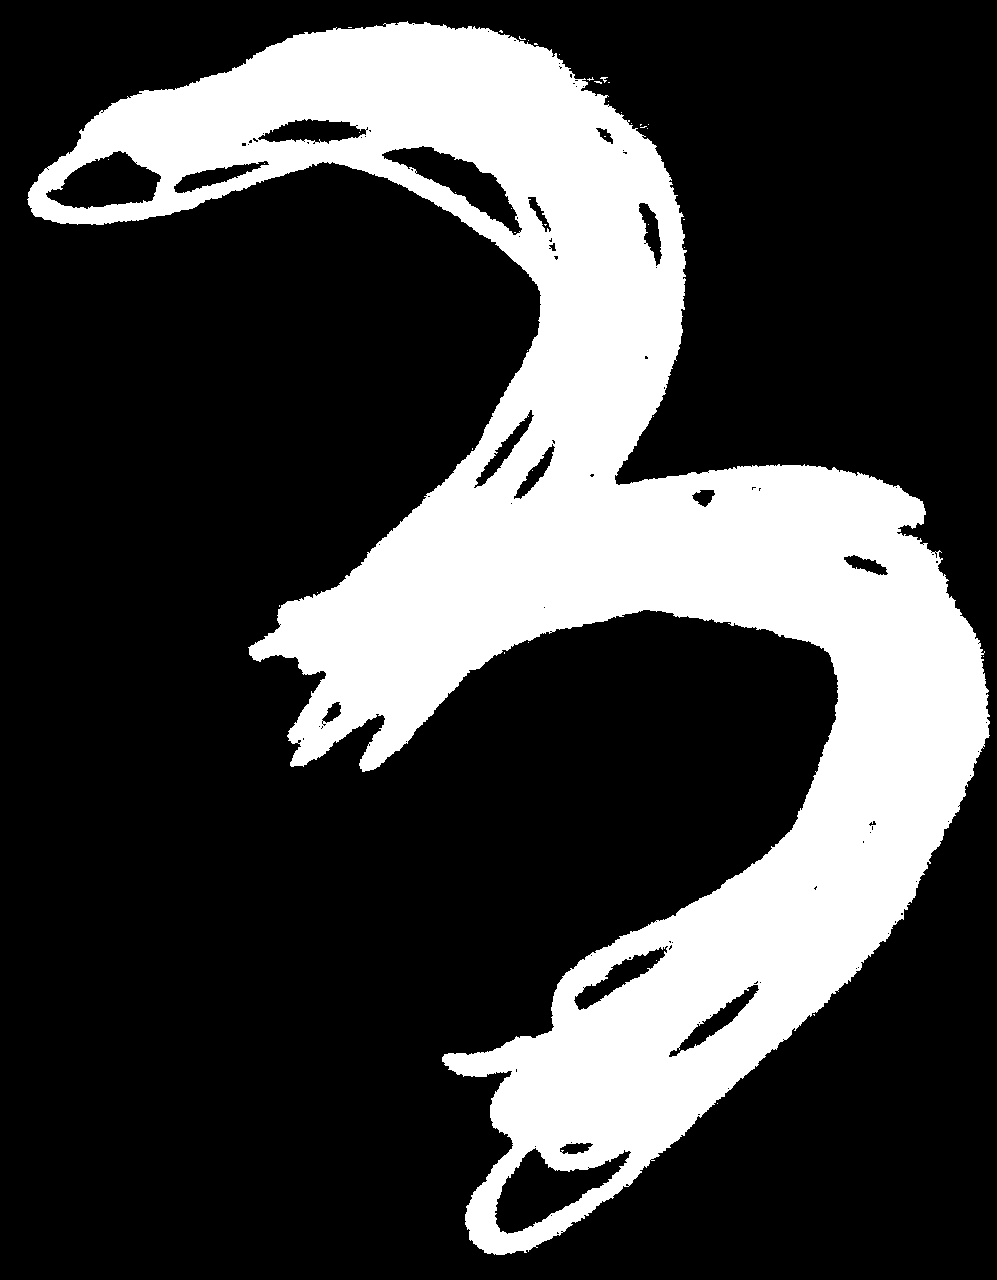

tensor([[-0.1858, -0.0011, -0.0323, -0.0731,  0.1491,  0.0838,  0.0098, -0.1738,
          0.0841,  0.0949]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.1858, -0.0011, -0.0323, -0.0731,  0.1491,  0.0838,  0.0098, -0.1738,
          0.0841,  0.0949]], device='cuda:0')
the predicted label is 4


In [138]:
predicts = predict("/content/image/photo_2023-04-20_00-53-01.jpg",model)

print("the predicted label is {}".format(predicts))